In [1]:
from keras.utils import to_categorical
import numpy as np
from time import time

from keras.layers import Dense, Dropout, Input, Concatenate, Add, Dot
from keras.models import Model, Sequential, load_model
from keras.callbacks import EarlyStopping, TensorBoard
from keras import regularizers

/home/voldemort/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

['/job:localhost/replica:0/task:0/device:GPU:0']

In [3]:
from recsys.wide_deep import WideDeep
import recsys.evaluate as ev

In [4]:
import pandas as pd
import numpy as np

In [5]:
train_ratings = pd.read_csv('data/train_ratings_set.csv')
book_features = pd.read_csv('data/books_with_latent_features.csv')
user_features = pd.read_csv('data/user_features_final.csv')

In [67]:
train_ratings.head()

,user_id,book_id,rating
0,36210,687,2
1,8,1509,1
2,42833,3128,4
3,39774,27,3
4,28108,1120,5


In [68]:
book_features.head()

,book_id,books_count,original_publication_year,average_rating,ratings_count,work_ratings_count,work_text_reviews_count,ratings_1,ratings_2,ratings_3,...,15,16,17,18,19,20,21,22,23,24
0,1,1.151500,0.170121,1.327789,30.036789,29.098997,24.874634,9.851855,12.846534,19.219327,...,0.000000,0.000000,0.000000,0.000668,0.00000,0.0,0.0,0.000000,0.009848,0.000000
1,2,2.436243,0.108104,1.720847,28.904534,28.250940,11.911526,11.176438,10.143953,15.538545,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.0,0.0,0.000000,0.000000,0.000000
2,3,0.881646,0.153207,-1.698765,24.229710,22.987143,15.037225,68.549476,44.633867,27.389823,...,0.000000,0.000000,0.026678,0.000000,0.00000,0.0,0.0,0.000000,0.007945,0.000000
3,4,2.412777,-0.100498,0.974035,19.983656,19.554820,11.375772,8.904196,11.763752,15.251665,...,0.002680,0.000000,0.000000,0.009918,0.04148,0.0,0.0,0.000847,0.021077,0.031681
4,5,7.510681,-0.297825,-0.440977,16.710904,16.174804,8.012977,12.793850,20.018253,20.833128,...,0.011253,0.000036,0.000000,0.000000,0.00000,0.0,0.0,0.000000,0.000000,0.000000


In [69]:
user_features.head()

,user_id,avg_rating,0,1,2,3,4,5,6,7,...,15,16,17,18,19,20,21,22,23,24
0,6.0,4.285714,0.195982,0.01082,0.008561,0.007327,0.03029,0.032636,0.028151,0.012982,...,0.001723,0.0,0.011177,0.020266,0.015214,0.020975,0.041102,0.010981,0.012653,0.06773
1,1006.0,3.784615,0.195982,0.01082,0.008561,0.007327,0.03029,0.032636,0.028151,0.012982,...,0.001723,0.0,0.011177,0.020266,0.015214,0.020975,0.041102,0.010981,0.012653,0.06773
2,2006.0,4.100000,0.195982,0.01082,0.008561,0.007327,0.03029,0.032636,0.028151,0.012982,...,0.001723,0.0,0.011177,0.020266,0.015214,0.020975,0.041102,0.010981,0.012653,0.06773
3,3006.0,3.819444,0.195982,0.01082,0.008561,0.007327,0.03029,0.032636,0.028151,0.012982,...,0.001723,0.0,0.011177,0.020266,0.015214,0.020975,0.041102,0.010981,0.012653,0.06773
4,4006.0,3.317647,0.195982,0.01082,0.008561,0.007327,0.03029,0.032636,0.028151,0.012982,...,0.001723,0.0,0.011177,0.020266,0.015214,0.020975,0.041102,0.010981,0.012653,0.06773


In [6]:
user_features['user_id'] = user_features.apply(lambda x: int(x['user_id']), axis=1)

In [7]:
train_data = train_ratings.merge(user_features, how='left', on='user_id')

In [8]:
train_data = train_data.merge(book_features, how='left', on='book_id')

In [73]:
train_data.head()

,user_id,book_id,rating,avg_rating,0_x,1_x,2_x,3_x,4_x,5_x,...,15_y,16_y,17_y,18_y,19_y,20_y,21_y,22_y,23_y,24_y
0,36210,687,2,3.536232,0.202367,0.033538,0.001456,0.005575,0.006220,0.035502,...,0.001187,0.001917,0.000825,0.0,0.002246,0.001787,0.003241,0.003036,0.004602,0.009414
1,8,1509,1,3.421053,0.199233,0.013608,0.000536,0.003621,0.023440,0.005159,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,42833,3128,4,4.611940,0.196320,0.021527,0.007529,0.007994,0.014450,0.030204,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,39774,27,3,3.523810,0.156639,0.050961,0.051112,0.004160,0.012483,0.067711,...,0.000000,0.000000,0.008164,0.0,0.000000,0.003095,0.000000,0.015545,0.000000,0.029988
4,28108,1120,5,4.678571,0.189999,0.032203,0.093174,0.000000,0.000000,0.085931,...,0.001789,0.001892,0.000725,0.0,0.003100,0.001592,0.004266,0.003174,0.004424,0.009140


In [74]:
train_data.shape

(4183180, 65)

In [7]:
import sys
sys.getsizeof(train_data)

2208719064

# Like/Dislike Prediction

In [8]:
y_train = train_data.apply(lambda x: 1 if x['rating'] > 3 else 0, axis=1)

In [13]:
x_columns = [c for c in train_data.columns if c not in ['user_id', 'book_id', 'rating']]

In [14]:
x_train = train_data[x_columns]

In [15]:
x_train = np.asarray(x_train)
y_train = np.asarray(y_train)

In [12]:
y_train[0]

0

In [92]:
wide_deep = WideDeep(num_classes=1, batch_size=128, lambda_1=0.01, extra_hidden=False)

In [93]:
wide_deep.fit(x_train, y_train)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_14 (InputLayer)           (None, 62)           0                                            
__________________________________________________________________________________________________
dense_62 (Dense)                (None, 512)          32256       input_14[0][0]                   
__________________________________________________________________________________________________
dropout_27 (Dropout)            (None, 512)          0           dense_62[0][0]                   
__________________________________________________________________________________________________
dense_63 (Dense)                (None, 128)          65664       dropout_27[0][0]                 
__________________________________________________________________________________________________
dropout_28

In [94]:
wide_deep = WideDeep(num_classes=1, batch_size=128, lambda_1=0.1, extra_hidden=False)
wide_deep.fit(x_train, y_train)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_15 (InputLayer)           (None, 62)           0                                            
__________________________________________________________________________________________________
dense_67 (Dense)                (None, 512)          32256       input_15[0][0]                   
__________________________________________________________________________________________________
dropout_29 (Dropout)            (None, 512)          0           dense_67[0][0]                   
__________________________________________________________________________________________________
dense_68 (Dense)                (None, 128)          65664       dropout_29[0][0]                 
__________________________________________________________________________________________________
dropout_30

In [95]:
wide_deep.deep.save('models/wide_deep_1_01_128_False.h5')

In [96]:
wide_deep = WideDeep(num_classes=1, batch_size=256, lambda_1=0.1, extra_hidden=False)
wide_deep.fit(x_train, y_train)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_16 (InputLayer)           (None, 62)           0                                            
__________________________________________________________________________________________________
dense_72 (Dense)                (None, 512)          32256       input_16[0][0]                   
__________________________________________________________________________________________________
dropout_31 (Dropout)            (None, 512)          0           dense_72[0][0]                   
__________________________________________________________________________________________________
dense_73 (Dense)                (None, 128)          65664       dropout_31[0][0]                 
__________________________________________________________________________________________________
dropout_32

In [16]:
wide_deep = WideDeep(num_classes=1, batch_size=128, lambda_1=0.1, extra_hidden=True)
wide_deep.fit(x_train, y_train)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 62)           0                                            
__________________________________________________________________________________________________
dense_6 (Dense)                 (None, 512)          32256       input_2[0][0]                    
__________________________________________________________________________________________________
dropout_4 (Dropout)             (None, 512)          0           dense_6[0][0]                    
__________________________________________________________________________________________________
dense_7 (Dense)                 (None, 256)          131328      dropout_4[0][0]                  
__________________________________________________________________________________________________
dropout_5 

In [17]:
wide_deep = WideDeep(num_classes=1, batch_size=128, lambda_1=0.5, extra_hidden=False)
wide_deep.fit(x_train, y_train)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 62)           0                                            
__________________________________________________________________________________________________
dense_12 (Dense)                (None, 512)          32256       input_3[0][0]                    
__________________________________________________________________________________________________
dropout_7 (Dropout)             (None, 512)          0           dense_12[0][0]                   
__________________________________________________________________________________________________
dense_13 (Dense)                (None, 128)          65664       dropout_7[0][0]                  
__________________________________________________________________________________________________
dropout_8 

In [18]:
wide_deep.deep.save('models/wide_deep_1_5_128_False.h5')

In [19]:
wide_deep = WideDeep(num_classes=1, batch_size=64, lambda_1=0.5, extra_hidden=False)
wide_deep.fit(x_train, y_train)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 62)           0                                            
__________________________________________________________________________________________________
dense_17 (Dense)                (None, 512)          32256       input_4[0][0]                    
__________________________________________________________________________________________________
dropout_9 (Dropout)             (None, 512)          0           dense_17[0][0]                   
__________________________________________________________________________________________________
dense_18 (Dense)                (None, 128)          65664       dropout_9[0][0]                  
__________________________________________________________________________________________________
dropout_10

# 1-5 Rating Prediction

In [9]:
y_train_5 = train_data['rating']
y_train_5 = to_categorical(y_train_5)

In [23]:
train_data['rating'].value_counts(dropna=False)

4    1496995
5    1388429
3     959931
2     250846
1      86979
Name: rating, dtype: int64

In [10]:
y_train_5.shape

(4183180, 6)

In [11]:
y_train_5 = train_data.apply(lambda x: x['rating'] - 1, axis=1)
y_train_5 = to_categorical(y_train_5)

In [36]:
y_train_5.shape

(4183180, 5)

In [37]:
wide_deep = WideDeep(num_classes=5, batch_size=128, lambda_1=0.1, extra_hidden=False)
wide_deep.fit(x_train, y_train_5)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           (None, 62)           0                                            
__________________________________________________________________________________________________
dense_46 (Dense)                (None, 512)          32256       input_10[0][0]                   
__________________________________________________________________________________________________
dropout_21 (Dropout)            (None, 512)          0           dense_46[0][0]                   
__________________________________________________________________________________________________
dense_47 (Dense)                (None, 128)          65664       dropout_21[0][0]                 
__________________________________________________________________________________________________
dropout_22

In [38]:
wide_deep.deep.save('models/wide_deep_5_1_128_False.h5')

In [39]:
wide_deep = WideDeep(num_classes=5, batch_size=128, lambda_1=0.5, extra_hidden=False)
wide_deep.fit(x_train, y_train_5)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           (None, 62)           0                                            
__________________________________________________________________________________________________
dense_51 (Dense)                (None, 512)          32256       input_11[0][0]                   
__________________________________________________________________________________________________
dropout_23 (Dropout)            (None, 512)          0           dense_51[0][0]                   
__________________________________________________________________________________________________
dense_52 (Dense)                (None, 128)          65664       dropout_23[0][0]                 
__________________________________________________________________________________________________
dropout_24

In [40]:
wide_deep = WideDeep(num_classes=5, batch_size=128, lambda_1=0.1, extra_hidden=True)
wide_deep.fit(x_train, y_train_5)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           (None, 62)           0                                            
__________________________________________________________________________________________________
dense_56 (Dense)                (None, 512)          32256       input_12[0][0]                   
__________________________________________________________________________________________________
dropout_25 (Dropout)            (None, 512)          0           dense_56[0][0]                   
__________________________________________________________________________________________________
dense_57 (Dense)                (None, 256)          131328      dropout_25[0][0]                 
__________________________________________________________________________________________________
dropout_26

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 62)           0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 512)          32256       input_1[0][0]                    
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 512)          0           dense_1[0][0]                    
__________________________________________________________________________________________________
dense_2 (Dense)      

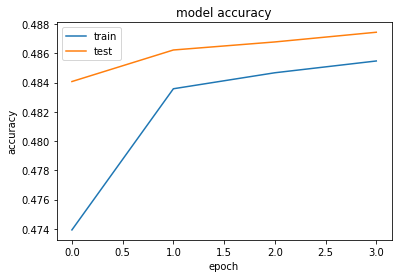

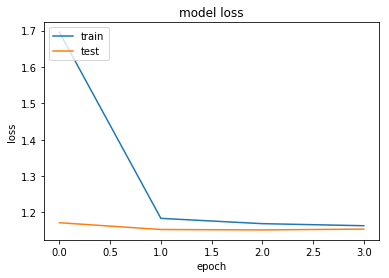

In [16]:
wide_deep = WideDeep(num_classes=5, batch_size=256, lambda_1=0.1, extra_hidden=True)
wide_deep.fit(x_train, y_train_5)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 62)           0                                            
__________________________________________________________________________________________________
dense_7 (Dense)                 (None, 512)          32256       input_2[0][0]                    
__________________________________________________________________________________________________
dropout_4 (Dropout)             (None, 512)          0           dense_7[0][0]                    
__________________________________________________________________________________________________
dense_8 (Dense)                 (None, 256)          131328      dropout_4[0][0]                  
__________________________________________________________________________________________________
dropout_5 

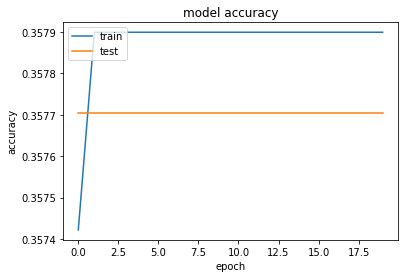

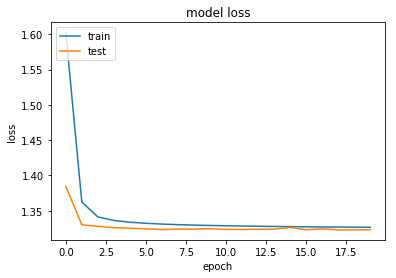

In [17]:
wide_deep = WideDeep(num_classes=5, batch_size=256, lambda_1=0.1, extra_hidden=True, epochs=20)
wide_deep.fit(x_train, y_train_5, early_stopping=False)

# Testing predictions

In [6]:
test_ratings = pd.read_csv('data/test_ratings_set.csv')
book_features = pd.read_csv('data/books_with_latent_features.csv')
user_features = pd.read_csv('data/user_features_final.csv')
test_data = test_ratings.merge(user_features, how='left', on='user_id')
test_data = test_data.merge(book_features, how='left', on='book_id')

In [6]:
binary_model = load_model('models/wide_deep_1_01_128_False.h5')

In [7]:
y_binary = test_ratings.apply(lambda x: 1 if x['rating'] > 3 else 0, axis=1)

In [7]:
x_test = test_data.drop(['user_id', 'book_id', 'rating'], axis=1)

In [9]:
y_binary = np.asarray(y_binary)
x_test = np.asarray(x_test)

In [13]:
evaluate = binary_model.evaluate(x_test, y_binary, verbose=1)

1792792/1792792 [==============================] - 106s 59us/step


In [14]:
evaluate

[0.5257303538434966, 0.7365238131364246]

In [16]:
predictions = binary_model.predict(x_test, verbose=1)

1792792/1792792 [==============================] - 154s 86us/step


In [17]:
predictions

array([[0.73439026],
       [0.8443906 ],
       [0.9035205 ],
       ...,
       [0.8843127 ],
       [0.7838348 ],
       [0.352266  ]], dtype=float32)

In [18]:
predictions.shape

(1792792, 1)

In [19]:
predictions_formated = np.rint(predictions)

In [20]:
predictions_formated

array([[1.],
       [1.],
       [1.],
       ...,
       [1.],
       [1.],
       [0.]], dtype=float32)

In [21]:
evaluation_data = test_data[['user_id', 'book_id', 'rating']].copy()
evaluation_data['pred_proba'] = predictions
evaluation_data['prediction'] = predictions_formated

In [22]:
evaluation_data['binary_rating'] = y_binary

In [23]:
cfm, p, r = ev.replay_binary_results(evaluation_data)

In [24]:
print(cfm)

[[ 204889  351503]
 [ 120855 1115545]]


In [32]:
print(p, r)

0.7604011593349366 0.9022525072791977


In [ ]:
evaluation_data.to_csv('data/backups/wd_eval1.csv', index=False)

In [4]:
evaluation_data = pd.read_csv('data/backups/wd_eval1.csv')
evaluation_data.head()

,user_id,book_id,rating,pred_proba,prediction,binary_rating
0,18218,920,3,0.734390,1.0,0
1,34091,967,4,0.844391,1.0,1
2,41266,71,5,0.903520,1.0,1
3,47336,760,5,0.643581,1.0,1
4,20893,453,3,0.621612,1.0,0


In [9]:
mAP, n = top_10_binary_results(evaluation_data)

0 users evaluated


/Users/emily-air13/anaconda3/lib/python3.6/site-packages/sklearn/metrics/ranking.py:526: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


500 users evaluated
1000 users evaluated
1500 users evaluated
2000 users evaluated
2500 users evaluated
3000 users evaluated
3500 users evaluated
4000 users evaluated
4500 users evaluated
5000 users evaluated
5500 users evaluated
6000 users evaluated
6500 users evaluated
7000 users evaluated
7500 users evaluated
8000 users evaluated
8500 users evaluated
9000 users evaluated
9500 users evaluated
10000 users evaluated
10500 users evaluated
11000 users evaluated
11500 users evaluated
12000 users evaluated
12500 users evaluated
13000 users evaluated
13500 users evaluated
14000 users evaluated
14500 users evaluated
15000 users evaluated
15500 users evaluated
16000 users evaluated
16500 users evaluated
17000 users evaluated
17500 users evaluated
18000 users evaluated
18500 users evaluated
19000 users evaluated
19500 users evaluated
20000 users evaluated
20500 users evaluated
21000 users evaluated
21500 users evaluated
22000 users evaluated
22500 users evaluated
23000 users evaluated
23500 us

In [10]:
print(mAP, n)

0.5929090723776069 0


### 5 classes

In [8]:
y_test_5 = test_data.apply(lambda x: x['rating'] - 1, axis=1)

In [9]:
y_test_5 = to_categorical(np.asarray(y_test_5))
x_test = np.asarray(x_test)

In [11]:
star5_model = load_model('models/wide_deep_5_1_128_False.h5')

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.


In [12]:
evaluation = star5_model.evaluate(x_test, y_test_5, verbose=1)

1792792/1792792 [==============================] - 28s 15us/step


In [13]:
evaluation

[1.1565596667748237, 0.48103126296873167]

In [14]:
predictions = star5_model.predict(x_test, verbose=1)

1792792/1792792 [==============================] - 17s 10us/step


In [15]:
predictions.shape

(1792792, 5)

In [16]:
predictions

array([[0.01657924, 0.04514957, 0.20334531, 0.4058831 , 0.32904282],
       [0.00650869, 0.02216436, 0.14680913, 0.4009271 , 0.42359075],
       [0.00446666, 0.01040739, 0.06184202, 0.23993082, 0.6833531 ],
       ...,
       [0.00487425, 0.01513677, 0.10773239, 0.36219245, 0.5100642 ],
       [0.00252846, 0.0192401 , 0.22556204, 0.53188074, 0.2207887 ],
       [0.05092024, 0.16127434, 0.41674414, 0.29408756, 0.07697359]],
      dtype=float32)

In [18]:
predictions_formated = np.argmax(predictions, axis=1)
predictions_formated

array([3, 4, 4, ..., 4, 3, 2])

In [19]:
predictions_formated = predictions_formated + 1
predictions_formated

array([4, 5, 5, ..., 5, 4, 3])

In [20]:
evaluation_data = test_data[['user_id', 'book_id', 'rating']].copy()
evaluation_data['pred_proba'] = predictions[:,4]
evaluation_data['prediction'] = predictions_formated

In [29]:
cfm, p, r = ev.replay_5star_results(evaluation_data)

In [30]:
cfm

array([[  1891,    438,  15715,  14629,   4487],
       [   748,    736,  48225,  48346,  10314],
       [   456,    509, 129521, 224463,  55914],
       [   178,    228,  89920, 372830, 178700],
       [   131,     95,  25814, 211093, 357411]])

In [31]:
print(p, r)

0.4782048316600647 0.4810312629685987


In [42]:
aps, mAP, binary_mAP, binary_aps, skipped = ev.top_10_5star_results(evaluation_data)

/home/voldemort/anaconda3/lib/python3.6/site-packages/sklearn/metrics/ranking.py:526: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


0 users evaluated
500 users evaluated
1000 users evaluated
1500 users evaluated
2000 users evaluated
2500 users evaluated
3000 users evaluated
3500 users evaluated
4000 users evaluated
4500 users evaluated
5000 users evaluated
5500 users evaluated
6000 users evaluated
6500 users evaluated
7000 users evaluated
7500 users evaluated
8000 users evaluated
8500 users evaluated
9000 users evaluated
9500 users evaluated
10000 users evaluated
10500 users evaluated
11000 users evaluated
11500 users evaluated
12000 users evaluated
12500 users evaluated
13000 users evaluated
13500 users evaluated
14000 users evaluated
14500 users evaluated
15000 users evaluated
15500 users evaluated
16000 users evaluated
16500 users evaluated
17000 users evaluated
17500 users evaluated
18000 users evaluated
18500 users evaluated
19000 users evaluated
19500 users evaluated
20000 users evaluated
20500 users evaluated
21000 users evaluated
21500 users evaluated
22000 users evaluated
22500 users evaluated
23000 users 

In [43]:
print(mAP, binary_mAP)

0.07100897147746114 0.6061237993002462


In [ ]:
evaluation_data.to_csv('data/backups/wd_eval5.csv', index=False)

In [6]:
evaluation_data = pd.read_csv('data/backups/wd_eval5.csv')
evaluation_data.head()

,user_id,book_id,rating,pred_proba,prediction
0,18218,920,3,0.329043,4
1,34091,967,4,0.423591,5
2,41266,71,5,0.683353,5
3,47336,760,5,0.163343,4
4,20893,453,3,0.215606,4
